In [108]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from matplotlib.ticker import MultipleLocator
import matplotlib as mpl

from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import distributions

import uncertainties as unc
from uncertainties import unumpy as unp

## Define country colours

In [109]:
scheme_colours = {
    'american_blue' : (60, 59, 110),
    'american_red' : (178, 34, 52),
    'white' : (255,255,255),
    'red' : (255,0,0),
    'blue': (0,0,255),
    'yellow': (255,255,0),
    'philippine_blue' : (0, 57, 166),
    'maximum_red' :  (213, 43, 30),
    'catalina_blue' : (0, 53, 128),
    'japanese_carmine' : (158, 48, 57),
    'medium_persian_blue' :  (0, 106, 167),
    'philippine_yellow' :(254, 204, 0),
    'philippine_red': (208, 12, 39),
    'true_blue': (0, 114, 206),
    'black':(0,0,0),
    'crimson_glory': (188, 0, 45),
    'spanish_green':(0, 146, 70),
    'deep_green':(1, 106, 27),
    'madder_lake':(206, 43, 55),
    'electric_red':(221, 0, 0),
    'tangerine_yellow':(255, 206, 0),
    'japan_red':(255,100,0),
    'baby_blue_eyes':(153, 204, 255),
    'gray':(180,180,180),
    'imperial_blue':(0, 31, 151),
    'school_bus_yellow':(255, 216, 0),
    'pearl_aqua':(143, 195, 189),
    'magenta':(255,0,255),
    'cyber_yellow' : (253,213,0)
    }

country_colors_dict= {'United States':['blue'],
                     'Canada':['red'],
                     'Russia':['gray'],#,'philippine_blue','maximum_red'],
                     'Finland':['catalina_blue'],
                     'Latvia':['japanese_carmine'],
                     'Sweden':['philippine_yellow'],
                     'Estonia':['baby_blue_eyes'],
                     'Japan':['japan_red'],
                     'Italy':['spanish_green'],
                     'Germany':['black'],
                      'Nagano':['japan_red'],
                      'N Italy':['spanish_green'],
                      #'British Columbia':['school_bus_yellow'],
                      'British Columbia':['black'],
                      'Ontario':['philippine_red'],
                      'Quebec':['imperial_blue'],
                      'Canadian Prairies':['deep_green'],
                      'Atlantic Canada':['pearl_aqua'],
                      'Northern Canada':['cyber_yellow']
                      #'Minnesota':['gray']
                     }
for country,colors in country_colors_dict.items():
    newcolors = [scheme_colours[color] for color in colors]
    newcolors = [tuple([float(c)/255. for c in color]) for color in newcolors]
    country_colors_dict[country] = newcolors

## Define some functions

In [110]:
## EXPONENTIAL FIT
def funcX(x, a, b, c):
    return a*np.exp(b*x) + c

# Uses scipy.optimize.curve_fit to model data with exponential function
def stats_summary(func,x,y, alpha_t = 0.05,display=True,stats_only=False):
    popt, pcov = curve_fit(func, x, y)
    residuals =  y - func(x, *popt)

    n = len(y)
    nparams = len(popt)
    dof = max(0, n - nparams) # number of degrees of freedom
    
    # Calculate a pseudo-Rsquared
    ss_res = np.sum(residuals**2)
    #print ss_res
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - ss_res/ss_tot
    msr = ss_tot / (nparams-1)
    mse = ss_res / dof
    ss_2 = ss_res
    dof_2 = dof
    ss_1 = ss_tot
    dof_1 = n-1
    fstat = (ss_1 - ss_2)/ss_2 * dof_2 / (dof_1 - dof_2)
    fstatp = 1.0-stats.f.cdf(fstat, 1.0*dof_1, 1.0*dof_2)
    
# student-t value for the dof and confidence level
    tval = distributions.t.ppf(1.0-alpha_t/2., dof)
    print ('    coeff  stderror   t    P>|t|    [{:.3f} {:.3f}]'.format(alpha_t/2., 1.0-alpha_t/2.))
    for i, p,var in zip(range(n), popt, np.diag(pcov)):
        sigma = var**0.5
        print ('p{}: {:6.3f} {:6.3f} {:6.3f} {:6.3e} [{:.3f}  {:.3f}]'.format(i, p, sigma, p/sigma,
                                 distributions.t.sf(np.abs(p/sigma), dof)*2,
                                  p - sigma*tval,
                                  p + sigma*tval))
    print ('R-squared: {:.3f}'.format(r_squared))
    # nparams - 1 not including constant term
    adj_r_squared =  1 - (1-r_squared)*(n-1)/(n-(nparams-1)-1)
    print ('Adj R-squared: {}'.format( adj_r_squared))
    print ('Observations: {}'.format(n))
    print ('Degrees of freedom: {}'.format(dof))
    
    print ('F-statistic: {:6.3f}'.format(fstat))
    print ('\tp-value: {:6.3e}'.format(fstatp))
    if display:
        plt.scatter(x,y,s=5)
        xarray = np.linspace(x.min(), x.max(),50)
        plt.plot(xarray, func(xarray,*popt))
    if stats_only:
        return r_squared, adj_r_squared, fstat, fstatp
    else:
        return popt, np.sqrt(np.diag(pcov)), pcov, tval

### Figure 2a

/Users/blagrave/.virtualenvs/extremeice/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


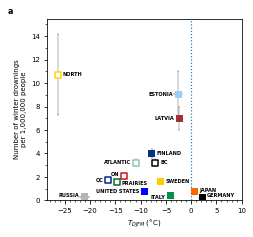

In [112]:
df = pd.read_csv('../data/mean_data.csv')

ind = ~df.country.isin(['Canada'])

x = df[ind].winter_djfm_airtemp_mean
xerr = df[ind].winter_djfm_airtemp_stderror
y = df[ind].drownings_per_million_mean
yerr = df[ind].drownings_per_million_stderror

countryindex = df[ind].country.tolist()
c = [country_colors_dict[i][0] for i in countryindex]

fig,ax = plt.subplots(figsize=(88./25.4, 88./25.4*0.9))

ax.set_ylim(0,12.)
ax.set_xlim(-28.5,10)

xoffset = 0.08*12.
yoffset = (12-0)*0.012

label_right = ['Northern Canada','Canadian Prairies','Sweden','Japan','Germany','Finland','Italy','British Columbia']
label_left = ['Russia','Quebec','Atlantic Canada','United States','Italy','Estonia','Latvia']
label_above = ['Russia','Ontario',
               'Japan','Germany']
label_below = ['Canadian Prairies','Italy']

prov_dict = {'Atlantic Canada':'Canada (Atlantic)','Ontario':'Canada (ON)',
            'Quebec':'Canada (QC)', 'Canadian Prairies':'Canada (Prairies)',
            'British Columbia':'Canada (BC)', 'Northern Canada':'Canada (North)'}

for xi,yi,xerri,yerri,ci,country in zip(x,y,xerr,yerr,c,countryindex):
    edgecolor='None'
    name = country
    label= name
    fillcolor = ci
    lw = 0.3
    canadamarker='s'
    canadasize=8*3.5
    canadafill = 'white'
    canadalw = 1.5
    canadaalpha = 0.8

    canadaedge=ci
    
    markersize = 8*6
    marker = 's'
    if name in prov_dict.keys():
        label = prov_dict[name]
        fillcolor = canadafill
        edgecolor = canadaedge
        markersize = canadasize
        marker = canadamarker
        lw = canadalw

    ax.errorbar(xi,yi,xerr=xerri,yerr=yerri,c='k',lw=0.3,
                ls='None',capsize=1,capthick=0.3)
    if name in label_right:
        ha = 'left'
        xoffset1 = xoffset
    if name in label_left:
        ha = 'right'
        xoffset1 = -xoffset
    if name in label_below:
        yoffset1 = -yoffset
    elif name in label_above:
        yoffset1 = yoffset
    else:
        yoffset1 = 0.
    ax.text(xi+xoffset1,yi+yoffset1, ''.join(label.split('Canada (')).strip(')').upper(), 
            weight='heavy',fontsize=5,ha=ha,va='center',zorder=5)
    ax.scatter(xi,yi, label=label,s=markersize,facecolor=fillcolor,
               edgecolor=edgecolor,alpha=1.0,marker=marker,lw=lw,
               zorder=4)

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.axvline(0,color='C0',lw=1.2,ls=':')
ax.set_xlabel(u'$T_{DJFM}$ (\N{DEGREE SIGN}C)',fontsize=7)

ax.set_ylabel('Number of winter drownings\nper 1,000,000 people',fontsize=7)
[l.set_fontsize(7) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(7) for l in ax.yaxis.get_ticklabels()]


ax.set_ylim(0,15.5)


fig.show()
filename = '../figures/mean_stderr_'

filename = filename+'TDJFM'

fig.text(0.01,0.97,'a',weight='bold',fontsize=8)
fig.subplots_adjust(bottom=0.14,top=0.95, left=0.17, right=0.95)

fig.savefig(filename+'.pdf')
fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.tif',dpi=300)

### Figure 2b

In [89]:
df = pd.read_csv('../data/yearly_data.csv')
df['country'] = pd.Categorical(df.country, ['Estonia','Latvia','Finland',
                                   'Atlantic Canada','Quebec','Ontario','Canadian Prairies',
                                   'British Columbia','Sweden','United States',
                                  'Russia'])
df.country.unique()

[Estonia, Latvia, Finland, Atlantic Canada, Quebec, ..., Canadian Prairies, British Columbia, Sweden, United States, Russia]
Length: 11
Categories (11, object): [Estonia, Latvia, Finland, Atlantic Canada, ..., British Columbia, Sweden, United States, Russia]

    coeff  stderror   t    P>|t|    [0.025 0.975]
p0:  9.338  0.722 12.937 3.806e-28 [7.915  10.762]
p1:  0.282  0.042  6.776 1.380e-10 [0.200  0.363]
p2:  1.611  0.269  5.992 9.639e-09 [1.081  2.141]
R-squared: 0.489
Adj R-squared: 0.48413150379238823
Observations: 201
Degrees of freedom: 198
F-statistic: 94.848
	p-value: 1.110e-16


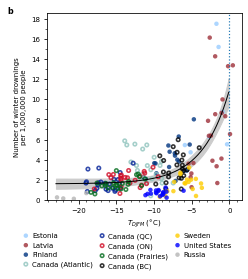

In [90]:
x = df.loc[:,'winter_djfm_airtemp'].values
y = df.loc[:,'drownings_per_million'].values


fig,ax = plt.subplots(figsize=(88./25.4, 88./25.4*1.1))
canadafill = 'None'
canadasize=12
canadalw = 1.6
canadaalpha = 0.8

marksize = 20

for name,group in df.groupby('country'):
    label = name
    edgecolor='None'
    fillcolor = country_colors_dict[name]
    markersize = marksize
    lw = 1.0
    if name == 'Atlantic Canada':
        fillcolor = canadafill
        label = 'Canada (Atlantic)'
        edgecolor = country_colors_dict[name]
        markersize = canadasize
        lw = canadalw
    elif name == 'Ontario':
        label = 'Canada (ON)'
        fillcolor = canadafill
        markersize = canadasize
        lw = canadalw
        edgecolor = [(i,j,k,canadaalpha) for i,j,k in country_colors_dict[name]]
    elif name == 'Quebec':
        label = 'Canada (QC)'
        fillcolor = canadafill
        markersize = canadasize
        lw = canadalw
        edgecolor = country_colors_dict[name]
    elif name == 'Canadian Prairies':
        label = 'Canada (Prairies)'
        fillcolor = canadafill
        markersize = canadasize
        lw = canadalw
        edgecolor = country_colors_dict[name]
    elif name == 'British Columbia':
        label = 'Canada (BC)'
        fillcolor = canadafill
        markersize = canadasize
        lw = canadalw
        edgecolor = country_colors_dict[name]
    
    if name in country_colors_dict:
        #print edgecolor, country_colors_dict[name]
        group.plot.scatter(s=markersize,alpha=0.8,
                           edgecolor=edgecolor,lw=lw,
                           x='winter_djfm_airtemp',y='drownings_per_million',
                           label=label,ax=ax,c=fillcolor)


ax.set_xlabel(u'$T_{DJFM}$ (\N{DEGREE SIGN}C)',fontsize=7)

ax.set_ylabel('Number of winter drownings\nper 1,000,000 people',fontsize=7)
[l.set_fontsize(7) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(7) for l in ax.yaxis.get_ticklabels()]
fig.subplots_adjust(bottom=0.27,top=0.95, left=0.17, right=0.95)



NSIG = 3.0
funcworking = funcX
popt,perr,pcov,tval = stats_summary(funcworking, x, y, alpha_t=0.05,display=False)

px = np.arange(-23, 0, 0.1)


a,b,c = unc.correlated_values(popt, pcov)
py = a*unp.exp(b*px)+c
nom = unp.nominal_values(py)
std = unp.std_devs(py)

lpb = nom- 1.96*std
upb = nom + 1.96*std
ax.fill_between(px, lpb,upb, color='0.8',zorder=0                   )

ax.plot(px, funcworking(px, *popt),ls='-',lw=1, color='0.0')
   
ax.set_ylim(0,18.5)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))


ax.legend(markerscale=1.,
          ncol=3,bbox_to_anchor=(0.4,-0.14),
          fontsize=7,loc='upper center',
          handletextpad=-0.1,
          columnspacing=0.3,
          frameon=False)
ax.axvline(0,color='C0',lw=1.2,ls=':')

fig.text(0.01,0.95,'b',weight='bold',fontsize=8)


filename = '../figures/drownings_exp'
filename = filename+'_TDJFM'

fig.savefig(filename+'.pdf')
fig.savefig(filename+'.png',dpi=300)
fig.savefig(filename+'.tif',dpi=300)


### Figure 3

In [105]:
df = pd.read_csv('../data/monthly_data.csv')

/Users/blagrave/.virtualenvs/extremeice/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/blagrave/.virtualenvs/extremeice/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/blagrave/.virtualenvs/extremeice/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax

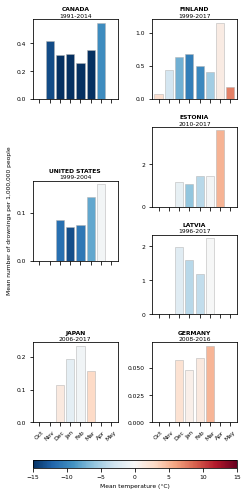

In [107]:
fontsize = 6
chsize = fontsize
df['country'] = pd.Categorical(df['country'], 
                                     ["Canada",
                                      "United States","Japan",
                                      "Finland",
                                      'Estonia',
                                            'Latvia',
                                       "Germany"])
df = df.sort_values('country')
plot_variable = 'drownings_per_million'
month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',10:'Oct',11:'Nov',12:'Dec'}
vmin,vmax = -15.0, 15.0
figwidth = 89.

figsize=(figwidth/25.4, figwidth/25.4*2.0)

hspace = 0.5
hspace = 0.35
wspace=0.4
bottom = 0.15
top = 0.95
left=0.14
right=0.95

plth = figsize[1]*(top - bottom) / (4.+hspace*3)
pltw = figsize[0]*(right - left) / (2.+wspace)

adj = (1. + hspace)*plth/2./figsize[1]



fig = plt.figure(figsize=figsize)


gs_row1 = plt.GridSpec(2,4, top=top,hspace=hspace,wspace=wspace,
                           bottom=bottom,left=left,right=right)
gs_row2 = plt.GridSpec(2,3, top=top,left=left+adj, right=right-adj,hspace=hspace,wspace=wspace,
                          bottom=bottom)

gs_col1 = plt.GridSpec(3,2, top=top,hspace=hspace+adj*figsize[1]/plth,wspace=wspace,
                           bottom=bottom,left=left,right=right)
gs_col2 = plt.GridSpec(4,2, top=top,left=left, right=right,hspace=hspace,wspace=wspace,
                          bottom=bottom)

ax0 = [fig.add_subplot(gs_col1[0,0])]
ax1 = [fig.add_subplot(gs_col2[0,1])]
leftax = [fig.add_subplot(gs_col1[i,0], sharex=ax0[0]) for i in range(1,3)]
rightax = [fig.add_subplot(gs_col2[i,1],sharex=ax1[0]) for i in range(1,4)]
axes = np.array(ax0+leftax+ax1+rightax)

for j, (name,group) in enumerate(df.groupby('country',sort=False)):
    ax = axes.flatten()[j]
 
    [i.label.set_fontsize(fontsize) for i in ax.xaxis.get_major_ticks()]
    [i.label.set_fontsize(fontsize) for i in ax.yaxis.get_major_ticks()]
    indnew = [ i  for i in [10,11,12,1,2,3,4,5] if i not in (group.groupby('month').sum().index.tolist())]
    indnew = group.groupby('month').sum().index.tolist()+indnew

    ratio = group.set_index('month').reindex(indnew).loc[[10,11,12,1,2,3,4,5],plot_variable].fillna(0) #(drownings_in_each_month/number_of_years)#/number_of_months)
    ratio.index = [month_dict[i] for i in ratio.index]

    footmp = group.set_index('month').reindex(indnew).loc[[10,11,12,1,2,3,4,5],'winter_djfm_airtemp']
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    f2rgb = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('RdBu_r'))

    colormap = f2rgb.to_rgba(footmp)
    f2rgb.set_array(footmp)
    edgecolor='0.7'
    
    ratio.plot.bar(color=colormap,edgecolor=edgecolor,lw=0.5,width=0.8,ax=ax)
    maxval = 500.
    if (j==1):
        ax.set_ylabel('Mean number of drownings per 1,000,000 people',fontsize=fontsize)
    else:
           
        ax.yaxis.set_ticks_position('left')
        [i.set_fontsize(chsize) for i in ax.yaxis.get_ticklabels()]

    if (ratio.max()>maxval):
        ind2 = (ratio > maxval)
        indices = ratio[ind2].index.values
        textvalue = ratio[ind2].values
        for ind3,txt in zip(indices, textvalue):
            ax.text((pd.to_datetime('1 {}, 2000'.format(ind3)).month+3)%12-1,
                maxval*0.9, '{:.1f}'.format(txt),ha='center')
    ax.set_xlabel('')
    ax.text(0.5,1.1,'{}'.format(name.upper()),ha='center',transform=ax.transAxes,fontsize=fontsize,weight='heavy')
    ax.text(0.5,1.02,'{}-{}'.format(int(group.minyear.min()), int(group.maxyear.max())),ha='center',transform=ax.transAxes,fontsize=fontsize)
    [ax.get_xticklabels()[i].set_rotation(45) for i in range(len(ax.get_xticklabels()))]
    [ax.get_xticklabels()[i].set_fontsize(fontsize) for i in range(len(ax.get_xticklabels()))]

    if ((j == 10) | (j== 12)):
        barwidth = 0.015
        barheight= plth / figsize[1]
        baroffset = 0.02
        if j==3:
            rightbar = (left*figsize[0] + pltw*(4+wspace*3))/figsize[0]+baroffset
            bottombar = (bottom*figsize[1] + plth*(1+hspace))/figsize[1]
        else:
            rightbar = ((left+adj)*figsize[0] + pltw*(3+wspace*2))/figsize[0]+baroffset
            bottombar = bottom
        cbaxes = fig.add_axes([rightbar,bottombar, barwidth, barheight]) 
        cb = fig.colorbar(f2rgb, cax = cbaxes)

        cb.set_label(u'Mean temperature (\N{DEGREE SIGN}C)',fontsize=fontsize)
        cb.ax.tick_params(labelsize=fontsize)
cbaxes = fig.add_axes([left, bottom*0.4, (right-left), 0.015]) 
cb = plt.colorbar(f2rgb,
                      cax=cbaxes,orientation='horizontal')
cb.set_label(u'Mean temperature (\N{DEGREE SIGN}C)',fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

fig.subplots_adjust(hspace=hspace,left=left,right=right,top=top,bottom=bottom)

fig.savefig('../figures/monthly_drownings_by_country.tif',dpi=300)
fig.savefig('../figures/monthly_drownings_by_country.png',dpi=300)
fig.savefig('../figures/monthly_drownings_by_country.pdf')
plt.show()